Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


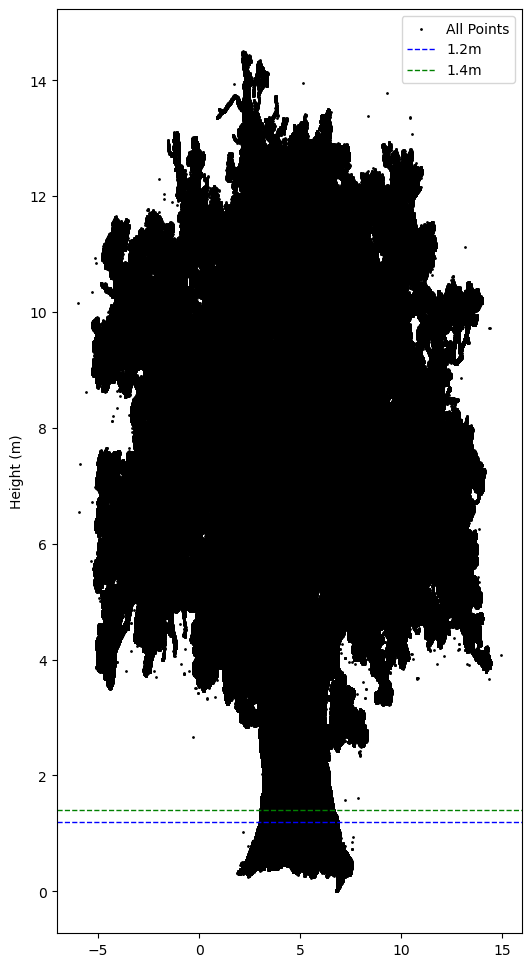

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

def load_point_cloud(file_path):
    """
    This function reads a point cloud file and returns the points as a NumPy array.

    Parameters:
    file_path (str): The path to the point cloud file.

    Returns:
    np.ndarray: The point cloud data in a NumPy array format.
    """
    # Read the point cloud file
    point_cloud = o3d.io.read_point_cloud(file_path)
    return np.asarray(point_cloud.points)

def plot_tree_height(points, z_min, z_max):
    """
    This function plots the height of a tree based on point cloud data.
    
    Parameters:
    points (np.ndarray): The point cloud data (x, y, z coordinates).
    z_min (float): The lower bound of the height range (e.g., 1.2 meters).
    z_max (float): The upper bound of the height range (e.g., 1.4 meters).
    """
    # Set the lowest point of the point cloud data to z = 0
    points[:, 2] -= np.min(points[:, 2])
    
    # Create a new figure with custom size
    plt.figure(figsize=(6, 12))
    
    # Plot the xz scatter plot of all points
    plt.scatter(points[:, 0], points[:, 2], c='black', s=1, label='All Points')
    
    # Add horizontal lines to mark the height range
    plt.axhline(y=z_min, color='blue', linestyle='--', linewidth=1, label='1.2m')
    plt.axhline(y=z_max, color='green', linestyle='--', linewidth=1, label='1.4m')
    
    # Set the figure title and axis labels (removing the title and x-axis label)
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel('Height (m)')
    plt.legend()
    
    # Adjust the aspect ratio of the plot
    plt.gca().set_aspect('auto', adjustable='box')
    
    # Display the plot
    plt.show()

# Set the file path for the point cloud file
file_path = r"C:\Users\wenru\Desktop\TLS TREE\2023-05-25.27.signing-oak.tree - Cloud.clone.ply"

# Load the point cloud data
points = load_point_cloud(file_path)

# Set the height range
z_min = 1.2
z_max = 1.4

# Plot the tree height graph
plot_tree_height(points, z_min, z_max)


<class 'shapely.geometry.polygon.Polygon'>
fDBH: 3.7774482458692233
AlphaShape Girth: 12.188513768517689
Circle Girth: 11.867203658538402
<class 'shapely.geometry.polygon.Polygon'>
fDBH: 3.8931264966718855
AlphaShape Girth: 12.547775363450528
Circle Girth: 12.230617601440164


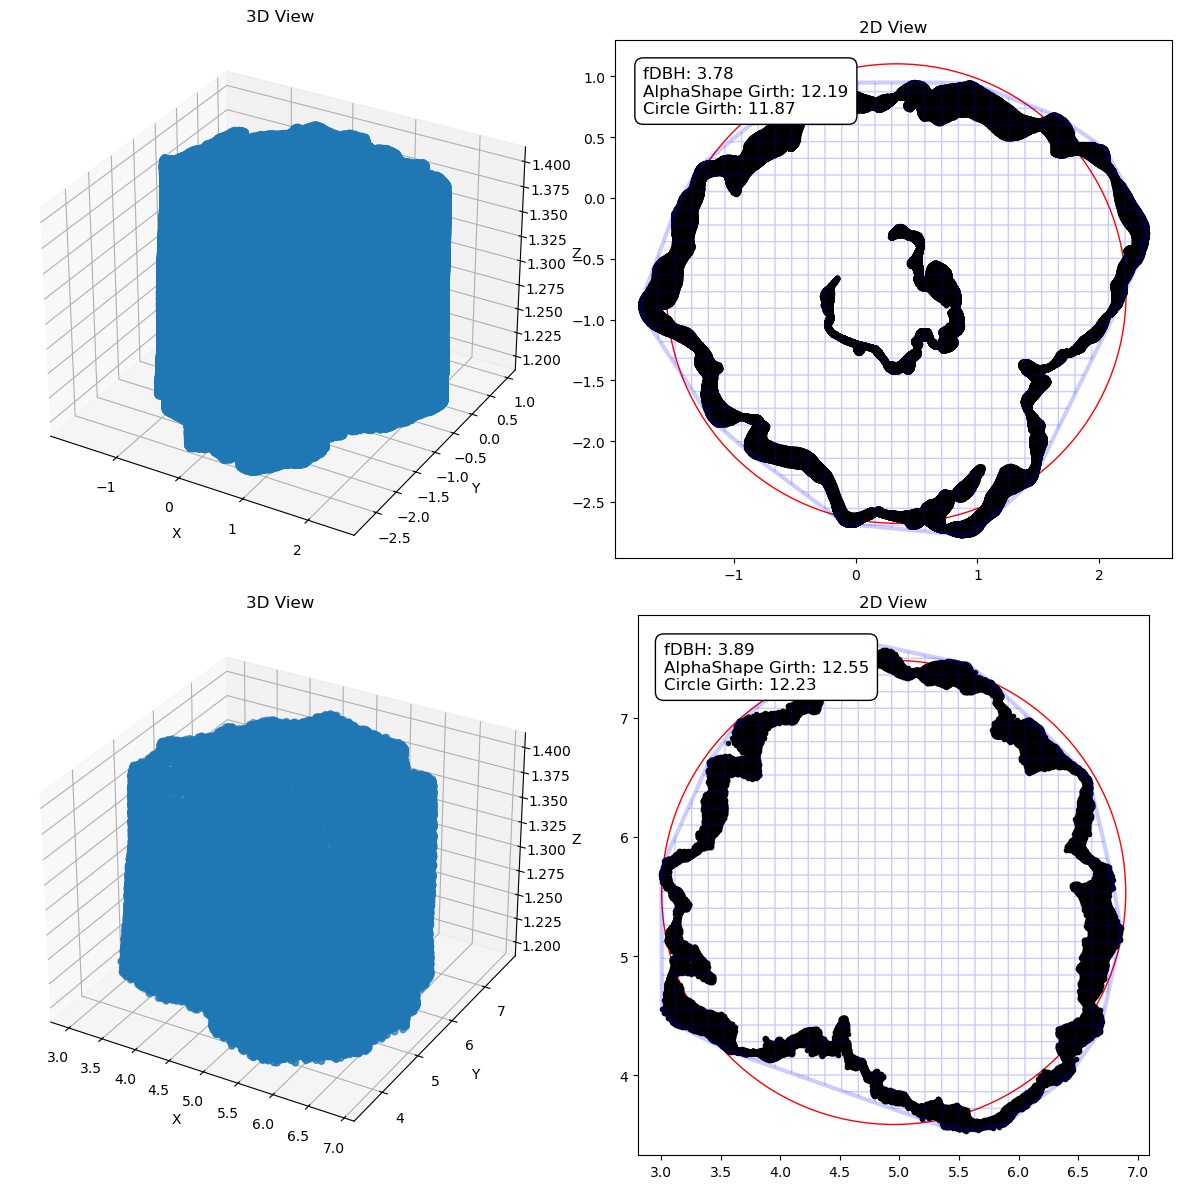

In [2]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import alphashape

def process_point_cloud(file_path, z_min, z_max, ax_3d, ax_2d):
    """
    This function processes a point cloud file, extracts a cross-section within a specified height range,
    calculates the AlphaShape, and visualizes the results in both 3D and 2D plots.

    Parameters:
    file_path (str): The path to the point cloud file.
    z_min (float): The lower bound of the height range (e.g., 1.2 meters).
    z_max (float): The upper bound of the height range (e.g., 1.4 meters).
    ax_3d (Axes3D): The 3D axis for plotting the point cloud.
    ax_2d (Axes): The 2D axis for plotting the AlphaShape and DBH.
    """
    # Load the point cloud file
    point_cloud = o3d.io.read_point_cloud(file_path)
    pcd = np.asarray(point_cloud.points)

    # Set the lowest point of the point cloud data to z = 0
    pcd[:, 2] -= np.min(pcd[:, 2])

    # Extract a cross-section of points within the specified height range (z_min to z_max)
    filtered_pcd = pcd[(pcd[:, 2] >= z_min) & (pcd[:, 2] <= z_max)]

    # Visualize the 3D scatter plot of the cross-section
    ax_3d.scatter(filtered_pcd[:, 0], filtered_pcd[:, 1], filtered_pcd[:, 2])
    ax_3d.set_title("3D View")
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')

    # Extract the x and y coordinates of the points
    points = filtered_pcd[:, :2]

    # Calculate the AlphaShape (concave hull) of the points
    alpha_shape = alphashape.alphashape(points, 0.)
    print(type(alpha_shape))  # Debugging: Print the type of the AlphaShape

    # Calculate fDBH (Diameter at Breast Height) using the area of the AlphaShape
    fDBH = np.sqrt(4. * alpha_shape.area / np.pi)
    print('fDBH:', fDBH)  # Debugging: Print the calculated fDBH

    # Calculate the centroid (center of mass) of the AlphaShape
    centroid = alpha_shape.centroid

    # Create a circle at the centroid with a radius equal to fDBH/2
    circle = plt.Circle((centroid.x, centroid.y), radius=fDBH / 2., color='r', fc='y', fill=False)

    # Add the circle to the 2D plot
    ax_2d.add_patch(circle)

    # Ensure the aspect ratio is equal to maintain the shape of the circle
    ax_2d.set_aspect('equal', 'box')

    # Plot the x, y points as a scatter plot in the 2D view
    ax_2d.scatter(points[:, 0], points[:, 1], c='k', marker='.', label='data')

    # Plot the AlphaShape outline in the 2D view
    if isinstance(alpha_shape, Polygon):
        ax_2d.fill(*alpha_shape.exterior.xy, alpha=0.2, ec='blue', lw=3, hatch='+', fill=None)
        # Calculate the girth (perimeter) of the AlphaShape
        alphashape_girth = alpha_shape.length
    elif isinstance(alpha_shape, MultiPolygon):
        alphashape_girth = sum(polygon.length for polygon in alpha_shape.geoms)
        for polygon in alpha_shape.geoms:
            ax_2d.fill(*polygon.exterior.xy, alpha=0.2, ec='blue', lw=3, hatch='+', fill=None)

    # Calculate the girth (perimeter) of the circle based on fDBH
    circle_girth = np.pi * fDBH

    # Print the calculated girths for debugging
    print('AlphaShape Girth:', alphashape_girth)
    print('Circle Girth:', circle_girth)

    # Add text annotations to the 2D plot with fDBH and girth information
    textstr = '\n'.join((
        f'fDBH: {fDBH:.2f}',
        f'AlphaShape Girth: {alphashape_girth:.2f}',
        f'Circle Girth: {circle_girth:.2f}'))
    
    # Place the text annotation in the 2D plot
    ax_2d.text(0.05, 0.95, textstr, transform=ax_2d.transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

    ax_2d.set_title("2D View")

# Set the paths to the point cloud files and the Z-axis height range
file_path_1 = r"C:\Users\wenru\Desktop\POLYCAM\The Signing Oak-pc-poly\point_cloud.ply"
file_path_2 = r"C:\Users\wenru\Desktop\TLS STEM\2023-05-25.27.signing-oak.stem.ply"

# Define the Z-axis height range for the cross-sections
z_min = 1.2
z_max = 1.4

# Create subplots for visualizing the two point clouds
fig = plt.figure(figsize=(12, 12))

# Add 3D and 2D subplots for the first and second point clouds
ax_3d_1 = fig.add_subplot(221, projection='3d')
ax_2d_1 = fig.add_subplot(222)
ax_3d_2 = fig.add_subplot(223, projection='3d')
ax_2d_2 = fig.add_subplot(224)

# Process and display the two point clouds in the respective subplots
process_point_cloud(file_path_1, z_min, z_max, ax_3d_1, ax_2d_1)
process_point_cloud(file_path_2, z_min, z_max, ax_3d_2, ax_2d_2)

# Automatically adjust the layout of the plots for better visualization
plt.tight_layout()

# Display the figure with all subplots
plt.show()


Cluster 0 fDBH: 2.6853676691806743
Cluster 0 AlphaShape Girth: 8.7955915654586
Cluster 0 Circle Girth: 8.436331341685552
Cluster 1 fDBH: 0.30060452865375403
Cluster 1 AlphaShape Girth: 1.1426354042281341
Cluster 1 Circle Girth: 0.9443769788544562
Cluster 0 fDBH: 0.507299194266507
Cluster 0 AlphaShape Girth: 1.9110975655643523
Cluster 0 Circle Girth: 1.5937274218796798
Cluster 1 fDBH: 0.5819024860759691
Cluster 1 AlphaShape Girth: 1.994496965874127
Cluster 1 Circle Girth: 1.8281005753619013


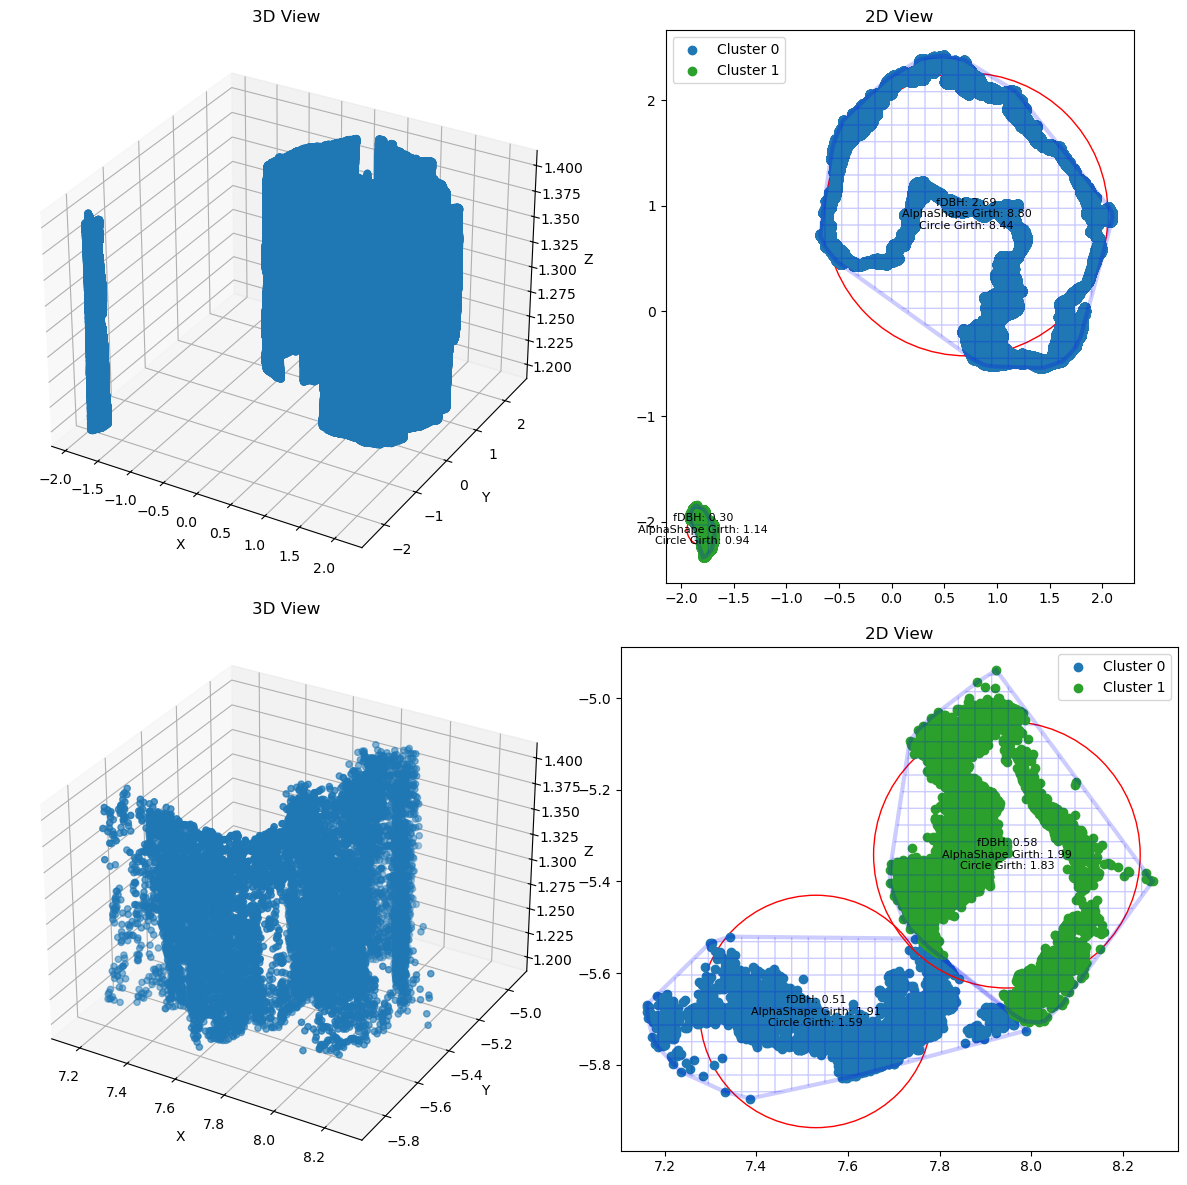

In [3]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import alphashape
from sklearn.cluster import KMeans

def process_point_cloud(file_path, z_min, z_max, n_clusters, ax_3d, ax_2d):
    """
    This function processes a point cloud file, extracts a cross-section within a specified height range,
    applies K-means clustering to the extracted points, computes the AlphaShape for each cluster,
    and visualizes the results in both 3D and 2D plots.

    Parameters:
    file_path (str): The path to the point cloud file.
    z_min (float): The lower bound of the height range (e.g., 1.2 meters).
    z_max (float): The upper bound of the height range (e.g., 1.4 meters).
    n_clusters (int): The number of clusters for K-means clustering.
    ax_3d (Axes3D): The 3D axis for plotting the point cloud.
    ax_2d (Axes): The 2D axis for plotting the AlphaShape and DBH for each cluster.
    """
    # Load the point cloud file
    point_cloud = o3d.io.read_point_cloud(file_path)
    pcd = np.asarray(point_cloud.points)

    # Set the lowest point of the point cloud data to z = 0
    pcd[:, 2] -= np.min(pcd[:, 2])

    # Extract a cross-section of points within the specified height range (z_min to z_max)
    filtered_pcd = pcd[(pcd[:, 2] >= z_min) & (pcd[:, 2] <= z_max)]

    # Visualize the 3D scatter plot of the cross-section
    ax_3d.scatter(filtered_pcd[:, 0], filtered_pcd[:, 1], filtered_pcd[:, 2])
    ax_3d.set_title(f"3D View")
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')

    # Extract the x and y coordinates of the points
    points = filtered_pcd[:, :2]

    # Apply K-means clustering on the extracted points
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(points)
    labels = kmeans.labels_  # Get the cluster labels for each point

    # Loop through each cluster to calculate and visualize fDBH and AlphaShape girth
    for cluster in range(n_clusters):
        cluster_points = points[labels == cluster]  # Extract points for the current cluster
        
        # Calculate the AlphaShape (concave hull) of the cluster points
        alpha_shape = alphashape.alphashape(cluster_points, 0.)
        
        # Calculate fDBH (Diameter at Breast Height) using the area of the AlphaShape
        fDBH = np.sqrt(4. * alpha_shape.area / np.pi)
        print(f'Cluster {cluster} fDBH:', fDBH)  # Print the calculated fDBH for each cluster
        
        # Calculate the girth (perimeter) of the AlphaShape
        if isinstance(alpha_shape, Polygon):
            alphashape_girth = alpha_shape.length
        elif isinstance(alpha_shape, MultiPolygon):
            alphashape_girth = sum(polygon.length for polygon in alpha_shape.geoms)
        print(f'Cluster {cluster} AlphaShape Girth:', alphashape_girth)
        
        # Calculate the girth of a circle based on fDBH
        circle_girth = np.pi * fDBH
        print(f'Cluster {cluster} Circle Girth:', circle_girth)
        
        # Calculate the centroid (center of mass) of the AlphaShape
        centroid = alpha_shape.centroid
        
        # Create a circle at the centroid with a radius equal to fDBH/2
        circle = plt.Circle((centroid.x, centroid.y), radius=fDBH / 2., color='r', fc='y', fill=False)
        
        # Add the circle to the 2D plot
        ax_2d.add_patch(circle)
        
        # Plot the cluster points as a scatter plot in the 2D view
        ax_2d.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
        
        # Plot the AlphaShape outline in the 2D view
        if isinstance(alpha_shape, Polygon):
            ax_2d.fill(*alpha_shape.exterior.xy, alpha=0.2, ec='blue', lw=3, hatch='+', fill=None)
        elif isinstance(alpha_shape, MultiPolygon):
            for polygon in alpha_shape.geoms:
                ax_2d.fill(*polygon.exterior.xy, alpha=0.2, ec='blue', lw=3, hatch='+', fill=None)
        
        # Add a text annotation at the centroid displaying fDBH and girth values
        ax_2d.text(centroid.x, centroid.y, f'fDBH: {fDBH:.2f}\nAlphaShape Girth: {alphashape_girth:.2f}\nCircle Girth: {circle_girth:.2f}', fontsize=8, ha='center', va='center')

    ax_2d.set_title(f"2D View")
    ax_2d.set_aspect('equal', 'box')
    ax_2d.legend()

# Set the paths to the point cloud files and the Z-axis height range
file_path_1 = r"C:\Users\wenru\Desktop\POLYCAM\Belvoir Oak 1-pc-poly\point_cloud.ply"
file_path_2 = r"C:\Users\wenru\Desktop\TLS STEM\2023-05-16.6.marton-oak.stem4.ply"

# Define the Z-axis height range for the cross-sections
z_min = 1.2
z_max = 1.4

# Set the number of clusters for K-means clustering
n_clusters = 2  # You can adjust this based on the data

# Create subplots for visualizing the two point clouds
fig = plt.figure(figsize=(12, 12))

# Add 3D and 2D subplots for the first and second point clouds
ax_3d_1 = fig.add_subplot(221, projection='3d')
ax_2d_1 = fig.add_subplot(222)
ax_3d_2 = fig.add_subplot(223, projection='3d')
ax_2d_2 = fig.add_subplot(224)

# Process and display the two point clouds in the respective subplots
process_point_cloud(file_path_1, z_min, z_max, n_clusters, ax_3d_1, ax_2d_1)
process_point_cloud(file_path_2, z_min, z_max, n_clusters, ax_3d_2, ax_2d_2)

# Automatically adjust the layout of the plots for better visualization
plt.tight_layout()

# Display the figure with all subplots
plt.show()



In [4]:
import open3d as o3d
import numpy as np

def filter_point_cloud_by_height(file_path, z_min, z_max, output_path):
    """
    This function filters a point cloud by height (z-axis) and saves the filtered points to a new file.

    Parameters:
    file_path (str): The path to the input point cloud file.
    z_min (float): The minimum z value for filtering the point cloud.
    z_max (float): The maximum z value for filtering the point cloud.
    output_path (str): The path to save the filtered point cloud.
    """
    # Load the point cloud file
    point_cloud = o3d.io.read_point_cloud(file_path)
    
    # Convert the point cloud data to a NumPy array
    pcd = np.asarray(point_cloud.points)
    
    # Adjust the point cloud data such that the lowest point has z = 0
    pcd[:, 2] -= np.min(pcd[:, 2])
    
    # Filter the points within the specified height range
    filtered_pcd = pcd[(pcd[:, 2] >= z_min) & (pcd[:, 2] <= z_max)]
    
    # Create a new point cloud object with the filtered points
    filtered_point_cloud = o3d.geometry.PointCloud()
    filtered_point_cloud.points = o3d.utility.Vector3dVector(filtered_pcd)
    
    # Save the filtered point cloud to the specified output file
    o3d.io.write_point_cloud(output_path, filtered_point_cloud)
    
    print(f"Filtered point cloud saved to {output_path}")

# Example usage
file_path = r"C:\Users\wenru\Desktop\TLS STEM\2023-05-17.8.capon-oak.stem.ply"
output_path = r"C:\Users\wenru\Desktop\TLS STEM\2023-05-17.8.capon-oak.stem_filtered.ply"
z_min = 1.2  # Minimum height in meters
z_max = 1.4  # Maximum height in meters

# Filter the point cloud by height and save it to the output file
filter_point_cloud_by_height(file_path, z_min, z_max, output_path)


Filtered point cloud saved to C:\Users\wenru\Desktop\TLS STEM\2023-05-17.8.capon-oak.stem_filtered.ply


<class 'shapely.geometry.polygon.Polygon'>
fDBH: 3.3397711123561127
Alpha Girth: 11.483883382354861
Circle Girth: 10.492200391249375


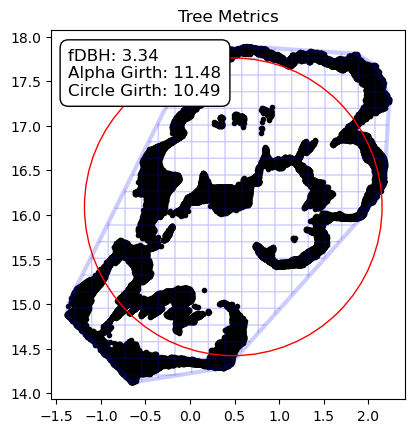

In [5]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
import alphashape

def calculate_tree_metrics(file_path):
    """
    This function calculates tree metrics such as fDBH (Functional Diameter at Breast Height) 
    and girth using the AlphaShape algorithm on a filtered point cloud.

    Parameters:
    file_path (str): The path to the point cloud file.
    """
    # Load the point cloud file
    point_cloud = o3d.io.read_point_cloud(file_path)
    pcd = np.asarray(point_cloud.points)

    # Extract the x and y coordinates from the point cloud
    points = pcd[:, :2]

    # Calculate the AlphaShape (concave hull) of the points
    alpha_shape = alphashape.alphashape(points, 0.)
    print(type(alpha_shape))  # Debugging: Print the type of the AlphaShape

    # Handle the case where the AlphaShape is empty
    if isinstance(alpha_shape, GeometryCollection) and len(alpha_shape) == 0:
        print("Alpha shape is empty. Skipping this file.")
        return

    # Calculate fDBH (Functional Diameter at Breast Height) using the area of the AlphaShape
    fDBH = np.sqrt(4. * alpha_shape.area / np.pi) if alpha_shape.area > 0 else 0
    print('fDBH:', fDBH)

    # Skip the file if fDBH is zero (invalid result)
    if fDBH == 0:
        print("fDBH is zero. Skipping this file.")
        return

    # Calculate the centroid (center of mass) of the AlphaShape
    centroid = alpha_shape.centroid

    # Calculate the girth (perimeter) of the AlphaShape
    if isinstance(alpha_shape, Polygon):
        alpha_girth = alpha_shape.length
    elif isinstance(alpha_shape, MultiPolygon):
        alpha_girth = sum(polygon.length for polygon in alpha_shape.geoms)

    # Calculate the girth of a circle based on fDBH
    circle_girth = np.pi * fDBH

    # Print the calculated girths for debugging
    print('Alpha Girth:', alpha_girth)
    print('Circle Girth:', circle_girth)

    # Visualization: Plot the points, AlphaShape, and fDBH circle
    fig, ax = plt.subplots()
    
    # Plot the x, y points from the point cloud
    ax.scatter(points[:, 0], points[:, 1], c='k', marker='.', label='data')

    # Plot the AlphaShape outline
    if isinstance(alpha_shape, Polygon):
        ax.fill(*alpha_shape.exterior.xy, alpha=0.2, ec='blue', lw=3, hatch='+', fill=None)
    elif isinstance(alpha_shape, MultiPolygon):
        for polygon in alpha_shape.geoms:
            ax.fill(*polygon.exterior.xy, alpha=0.2, ec='blue', lw=3, hatch='+', fill=None)

    # Plot the fDBH circle centered at the AlphaShape's centroid
    circle = plt.Circle((centroid.x, centroid.y), radius=fDBH / 2., color='r', fc='y', fill=False)
    ax.add_patch(circle)

    # Add text annotations for the fDBH and girth values
    textstr = '\n'.join((
        f'fDBH: {fDBH:.2f}',
        f'Alpha Girth: {alpha_girth:.2f}',
        f'Circle Girth: {circle_girth:.2f}'))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

    # Set the aspect ratio to be equal for proper scaling
    ax.set_aspect('equal', 'box')
    ax.set_title("Tree Metrics")
    
    # Display the plot
    plt.show()

# Example usage
file_path = r"C:\Users\wenru\Desktop\TLS STEM\2023-05-17.8.capon-oak.stem_filtered - seg.ply"

# Calculate tree metrics from the provided point cloud file
calculate_tree_metrics(file_path)
